In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
from PIL import Image


### Data 

In [2]:
TRAIN_DIR = 'data_dogscats/train/'
TEST_DIR = 'data_dogscats/test/'


In [3]:
IMAGE_SIZE = 96; # 96x96.  Also, 224, 96, 64, and 32 are also common
CHANNELS = 3
pixel_depth = 255.0  # Number of levels per pixel.

# for small-sample testing
TRAINING_AND_VALIDATION_SIZE_DOGS = 500 
TRAINING_AND_VALIDATION_SIZE_CATS = 500
TRAINING_AND_VALIDATION_SIZE_ALL  = 1000
TRAINING_SIZE = 700  # TRAINING_SIZE + VALID_SIZE must equal TRAINING_AND_VALIDATION_SIZE_ALL
VALID_SIZE = 300
TEST_SIZE_ALL = 200



train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] 
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

train_images = train_dogs[:TRAINING_AND_VALIDATION_SIZE_DOGS] + train_cats[:TRAINING_AND_VALIDATION_SIZE_CATS]
train_labels = np.array ((['dogs'] * TRAINING_AND_VALIDATION_SIZE_DOGS) + (['cats'] * TRAINING_AND_VALIDATION_SIZE_CATS))
test_images =  test_images[:TEST_SIZE_ALL]
test_labels = np.array (['unknownclass'] * TEST_SIZE_ALL)



In [4]:
def read_image(file_path):
    img = Image.open(file_path) #cv2.IMREAD_GRAYSCALE
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.BICUBIC)
    return img

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype=np.float32)

    for i, image_file in enumerate(images):
        image = read_image(image_file);
        image_data = np.array (image, dtype=np.float32);
        image_data[:,:,0] = (image_data[:,:,0].astype(float) - pixel_depth / 2) / pixel_depth
        image_data[:,:,1] = (image_data[:,:,1].astype(float) - pixel_depth / 2) / pixel_depth
        image_data[:,:,2] = (image_data[:,:,2].astype(float) - pixel_depth / 2) / pixel_depth
        
        data[i] = image_data; # image_data.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))    
    return data

train_normalized = prep_data(train_images)
test_normalized = prep_data(test_images)

print("Train shape: {}".format(train_normalized.shape))
print("Test shape: {}".format(test_normalized.shape))


Processed 0 of 1000
Processed 250 of 1000
Processed 500 of 1000
Processed 750 of 1000
Processed 0 of 200
Train shape: (1000, 96, 96, 3)
Test shape: (200, 96, 96, 3)


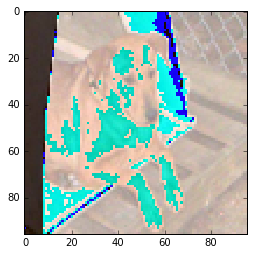

In [5]:
plt.imshow (train_normalized[0,:,:,:], interpolation='nearest')
plt.figure ()

In [6]:
np.random.seed (133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset_rand, train_labels_rand = randomize(train_normalized, train_labels)
test_dataset, test_labels = randomize(test_normalized, test_labels)

# split up into training + valid
valid_dataset = train_dataset_rand[:VALID_SIZE,:,:,:]
valid_labels =   train_labels_rand[:VALID_SIZE]
train_dataset = train_dataset_rand[VALID_SIZE:VALID_SIZE+TRAINING_SIZE,:,:,:]
train_labels  = train_labels_rand[VALID_SIZE:VALID_SIZE+TRAINING_SIZE]
print ('Training', train_dataset.shape, train_labels.shape)
print ('Validation', valid_dataset.shape, valid_labels.shape)
print ('Test', test_dataset.shape, test_labels.shape)

Training (700, 96, 96, 3) (700,)
Validation (300, 96, 96, 3) (300,)
Test (200, 96, 96, 3) (200,)


In [7]:
image_size = IMAGE_SIZE 
num_labels = 2
num_channels = 3 # rg

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (labels=='cats').astype(np.float32); # set dogs to 0 and cats to 1
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print ('Training set', train_dataset.shape, train_labels.shape)
print ('Validation set', valid_dataset.shape, valid_labels.shape)
print ('Test set', test_dataset.shape, test_labels.shape)

Training set (700, 96, 96, 3) (700, 2)
Validation set (300, 96, 96, 3) (300, 2)
Test set (200, 96, 96, 3) (200, 2)


In [17]:
len(test_labels)

200

In [43]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
  tf.float32, shape=[None, image_size*image_size])
  tf_train_dataset = tf.reshape(tf_train_dataset, [-1, image_size, image_size, num_channels])


  tf_train_labels = tf.placeholder(tf.float32, shape=[None, num_labels])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [int (image_size / 4 * image_size / 4 * depth), num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [-1, shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [53]:
def next_batch(data, labels, batch_size, batch_id):
    batch_data = data[batch_id:min(batch_id+ batch_size, len(data))]
    batch_labels = labels[batch_id:min(batch_id + batch_size, len(data))] 
    new_batch_id = (batch_id + batch_size) % (len(data) - batch_size)
    
    return batch_data, batch_labels, new_batch_id

In [54]:
def accuracy(predictions, labels):
   return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

num_steps = 1001
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print ("Initialized")
    batch_id = 0
    step = 1
    while step  < 1001:
        batch_data, batch_labels, new_batch_id = next_batch(train_dataset,train_labels, batch_size, batch_id)
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        batch_id = new_batch_id 
       
        if (step % 50 == 0):
            print ("Minibatch loss at step", step, ":", l)
            print ("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print ("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        step +=1



Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 50 : 0.676375
Minibatch accuracy: 62.5%
Validation accuracy: 50.3%
Minibatch loss at step 100 : 0.6694
Minibatch accuracy: 50.0%
Validation accuracy: 54.3%
Minibatch loss at step 150 : 1.01638
Minibatch accuracy: 18.8%
Validation accuracy: 52.3%
Minibatch loss at step 200 : 0.534816
Minibatch accuracy: 68.8%
Validation accuracy: 52.0%
Minibatch loss at step 250 : 0.468226
Minibatch accuracy: 87.5%
Validation accuracy: 54.3%
Minibatch loss at step 300 : 0.655348
Minibatch accuracy: 50.0%
Validation accuracy: 56.0%
Minibatch loss at step 350 : 0.534322
Minibatch accuracy: 62.5%
Validation accuracy: 59.3%
Minibatch loss at step 400 : 0.334389
Minibatch accuracy: 93.8%
Validation accuracy: 54.3%
Minibatch loss at step 450 : 0.403122
Minibatch accuracy: 68.8%
Validation accuracy: 56.7%
Minibatch loss at step 500 : 0.151555
Minibatch accuracy: 87.5%
Validation accuracy: 55.0%
Minibatc

KeyboardInterrupt: 

In [26]:
def accuracy(predictions, labels):
   return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

num_steps = 1001
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print ("Initialized")
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print ("Minibatch loss at step", step, ":", l)
      print ("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print ("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0 : 2.14413
Minibatch accuracy: 50.0%
Validation accuracy: 52.7%
Minibatch loss at step 50 : 0.680309
Minibatch accuracy: 50.0%
Validation accuracy: 48.7%
Minibatch loss at step 100 : 0.688593
Minibatch accuracy: 50.0%
Validation accuracy: 44.3%
Minibatch loss at step 150 : 0.773962
Minibatch accuracy: 37.5%
Validation accuracy: 49.0%
Minibatch loss at step 200 : 0.743205
Minibatch accuracy: 56.2%
Validation accuracy: 55.0%
Minibatch loss at step 250 : 0.480577
Minibatch accuracy: 87.5%
Validation accuracy: 56.3%
Minibatch loss at step 300 : 0.606706
Minibatch accuracy: 75.0%
Validation accuracy: 56.7%
Minibatch loss at step 350 : 0.354787
Minibatch accuracy: 93.8%
Validation accuracy: 56.3%
Minibatch loss at step 400 : 0.449632
Minibatch accuracy: 75.0%
Validation accuracy: 55.3%
Minibatch loss at step 450 : 0.490285
Minibatch accuracy: 75.0%
Validation accuracy: 52.7%
Minibatc

In [12]:
batch_size = 16
patch_size = 5
depth = 16
tf_train_dataset = tf.placeholder(
tf.float32, shape=(batch_size, image_size, image_size, num_channels))
tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
tf_valid_dataset = tf.constant(valid_dataset)
tf_test_dataset = tf.constant(test_dataset)

In [13]:

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128  

In [15]:
# We know that MNIST images are 28 pixels in each dimension

# Images are stored in one-dimensional arrays of this length.
img_size_flat = image_size * image_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (image_size, image_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 3

# Number of classes, one class for each of 10 digits.
num_classes = 2

In [16]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [17]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [18]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [23]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [24]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [72]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)


In [70]:
tf_train_dataset = tf.placeholder(
tf.float32, shape=(batch_size, image_size, image_size, num_channels))
tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
tf_valid_dataset = tf.constant(valid_dataset)
tf_test_dataset = tf.constant(test_dataset)

In [20]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [21]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [25]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [26]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [27]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=2,
                         use_relu=False)

In [28]:
y_pred = tf.nn.softmax(layer_fc2)


In [29]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [30]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

In [31]:
cost = tf.reduce_mean(cross_entropy)

In [32]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [33]:
y_true_cls = tf.argmax(tf_train_labels, dimension=1)

In [34]:

correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [35]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [36]:
session = tf.Session()
session.run(tf.global_variables_initializer())


In [37]:
batch_size = 16

In [74]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [46]:
tf_test_dataset.va

0

In [68]:
test_batch_size = 16

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(test_dataset)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)
        offset = (i * batch_size) % (test_labels.shape[0] - batch_size)
        batch_data = test_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = test_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        # Get the images from the test-set between index i and j.
        """images = test_dataset[i:j, :]

        # Get the associated labels.
        labels = test_labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {tf_train_dataset: images,
                     tf_train_labels: labels}"""

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = test_labels.values

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [75]:
optimize(100)
#print_test_accuracy()


4
(16, 2)


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_3' with dtype float and shape [16,2]
	 [[Node: Placeholder_3 = Placeholder[dtype=DT_FLOAT, shape=[16,2], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder_3', defined at:
  File "/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-3db2c5fd77b2>", line 4, in <module>
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1587, in placeholder
    name=name)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2043, in _placeholder
    name=name)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_3' with dtype float and shape [16,2]
	 [[Node: Placeholder_3 = Placeholder[dtype=DT_FLOAT, shape=[16,2], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
